In [1]:
%load_ext autoreload  
%autoreload 2

In [3]:
import pandas as pd

pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import stc_unicef_cpi.data.process_geotiff as pg
import h3.api.numpy_int as h3

from pathlib import Path


In [4]:
base_dir = Path("/Users/johnf/Downloads/higher_res_dssg/")
tiff_dir = base_dir / "500m_res"
econ_dir = base_dir / "econ"
clean_base = base_dir / "nga_clean_v2.csv"
rwi_path = base_dir / "NGA_relative_wealth_index.csv"
comm_zns = base_dir / "commuting-zones-bdrys.csv"
fb_conn = base_dir / "fb_conn_nigeria_train.csv"


In [5]:
nga_df = pd.read_csv(clean_base)


In [14]:
full_nga_data = pd.read_csv(
    "/Users/johnf/Downloads/raw_low_res_dssg/dhs/clean_nga_dhs.csv"
)


# Try mapping data to neighbours

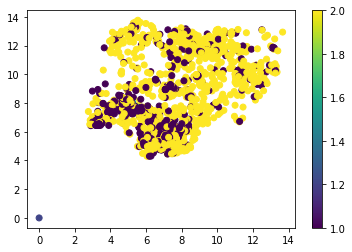

In [30]:
plt.scatter(nga_df.LONGNUM, nga_df.LATNUM, c=nga_df.location)
plt.colorbar()
plt.show()


In [23]:
full_nga_data.location.astype("category").describe()
# 1 is urban, 2 is rural


count     96184
unique        2
top           2
freq      61116
Name: location, dtype: int64

In [ ]:
full_nga_data["hex_incl_nbrs"] = full_nga_data[["location", "hex_code"]].apply(
    lambda row: h3.k_ring(row["hex_code"], 1)
    if row["location"] == 1
    else h3.k_ring(row["hex_code"], 2),
    axis=1,
)  # h3.hex_ring for hollow


In [56]:
sev_cols = [col for col in full_nga_data.columns if '_sev' in col]

In [71]:
other_cols = [
    col
    for col in full_nga_data.columns
    if
    (
        "int" in str(full_nga_data[col].dtype)
        or "float" in str(full_nga_data[col].dtype)
    )
]
agg_dict = {col: "mean" for col in other_cols}
agg_dict.update({idx:['mean','count'] for idx in sev_cols})
# agg_dict.update({"hhid": "count"})
new_df = full_nga_data.explode("hex_incl_nbrs").groupby(by=["hex_incl_nbrs"]).agg(
    agg_dict
)
new_df.columns = ['_'.join(col) for col in new_df.columns.values]


In [72]:
sev_cols

['sumpoor_sev',
 'dep_housing_sev',
 'dep_water_sev',
 'dep_sanitation_sev',
 'dep_nutrition_sev',
 'dep_health_sev',
 'dep_education_sev',
 'deprived_sev']

In [75]:
new_df.rename(columns={f"{sev}_mean":f"{sev.lstrip('dep_').rstrip('_sev')}_prev" for sev in sev_cols if sev!='deprived_sev'},inplace=True)
new_df.rename(columns={f"{sev}_count":f"{sev.lstrip('dep_').rstrip('_sev')}_count" for sev in sev_cols if sev!='deprived_sev'},inplace=True)
new_df.rename(columns={'ucation_count':'education_count','ucation_prev':'education_prev'},inplace=True)

In [76]:
new_df.head().columns

Index(['year_mean', 'round_mean', 'cluster_mean', 'hhid_mean', 'indid_mean',
       'location_mean', 'sex_mean', 'wealth_mean', 'wealthscore_mean',
       'age_mean', 'hhweight_mean', 'sumpoor_prev', 'sumpoor_count',
       'housing_prev', 'housing_count', 'water_prev', 'water_count',
       'sanitation_prev', 'sanitation_count', 'nutrition_prev',
       'nutrition_count', 'health_prev', 'health_count', 'education_prev',
       'education_count', 'deprived_sev_mean', 'deprived_sev_count',
       'region_mean', 'region2_mean', 'LATNUM_mean', 'LONGNUM_mean',
       'hex_code_mean'],
      dtype='object')

In [77]:
new_df.to_csv(base_dir / "nga_clean_expanded.csv")


In [80]:
new_df = pd.read_csv(base_dir / "nga_clean_expanded.csv")
new_df[new_df['nutrition_count']>=10]

,hex_incl_nbrs,year_mean,round_mean,cluster_mean,hhid_mean,indid_mean,location_mean,sex_mean,wealth_mean,wealthscore_mean,age_mean,hhweight_mean,sumpoor_prev,sumpoor_count,housing_prev,housing_count,water_prev,water_count,sanitation_prev,sanitation_count,nutrition_prev,nutrition_count,health_prev,health_count,education_prev,education_count,deprived_sev_mean,deprived_sev_count,region_mean,region2_mean,LATNUM_mean,LONGNUM_mean,hex_code_mean
19,609534214018170879,2018.0,72.0,701.000000,21.901099,5.219780,2.0,1.505495,1.461538,-108688.439560,7.076923,0.860969,1.615385,91,0.340659,91,0.000000,91,0.692308,91,0.538462,13,0.294118,17,0.694915,59,0.846154,91,3.0,10.0,13.282610,6.368814,6.095342e+17
20,609534214034948095,2018.0,72.0,701.000000,21.901099,5.219780,2.0,1.505495,1.461538,-108688.439560,7.076923,0.860969,1.615385,91,0.340659,91,0.000000,91,0.692308,91,0.538462,13,0.294118,17,0.694915,59,0.846154,91,3.0,10.0,13.282610,6.368814,6.095342e+17
21,609534214051725311,2018.0,72.0,701.000000,21.901099,5.219780,2.0,1.505495,1.461538,-108688.439560,7.076923,0.860969,1.615385,91,0.340659,91,0.000000,91,0.692308,91,0.538462,13,0.294118,17,0.694915,59,0.846154,91,3.0,10.0,13.282610,6.368814,6.095342e+17
22,609534214068502527,2018.0,72.0,701.000000,21.901099,5.219780,2.0,1.505495,1.461538,-108688.439560,7.076923,0.860969,1.615385,91,0.340659,91,0.000000,91,0.692308,91,0.538462,13,0.294118,17,0.694915,59,0.846154,91,3.0,10.0,13.282610,6.368814,6.095342e+17
23,609534214085279743,2018.0,72.0,701.000000,21.901099,5.219780,2.0,1.505495,1.461538,-108688.439560,7.076923,0.860969,1.615385,91,0.340659,91,0.000000,91,0.692308,91,0.538462,13,0.294118,17,0.694915,59,0.846154,91,3.0,10.0,13.282610,6.368814,6.095342e+17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17354,610288221397450751,2018.0,72.0,962.000000,36.773585,4.320755,2.0,1.490566,3.490566,32656.962264,7.169811,1.038178,0.264151,53,0.188679,53,0.000000,53,0.037736,53,0.000000,11,0.066667,15,0.032258,31,0.245283,53,5.0,300.0,4.641217,7.763440,6.102882e+17
17356,610288221632331775,2018.0,72.0,962.000000,36.773585,4.320755,2.0,1.490566,3.490566,32656.962264,7.169811,1.038178,0.264151,53,0.188679,53,0.000000,53,0.037736,53,0.000000,11,0.066667,15,0.032258,31,0.245283,53,5.0,300.0,4.641217,7.763440,6.102882e+17
17357,610288221649108991,2018.0,72.0,962.000000,36.773585,4.320755,2.0,1.490566,3.490566,32656.962264,7.169811,1.038178,0.264151,53,0.188679,53,0.000000,53,0.037736,53,0.000000,11,0.066667,15,0.032258,31,0.245283,53,5.0,300.0,4.641217,7.763440,6.102882e+17
17358,610288221665886207,2018.0,72.0,974.511905,23.666667,4.595238,2.0,1.440476,2.988095,-6354.559524,7.988095,0.660451,0.523810,84,0.000000,84,0.404762,84,0.095238,84,0.000000,16,0.055556,18,0.017241,58,0.428571,84,5.0,300.0,4.685343,7.806355,6.102882e+17


In [7]:
sev_cols = [col for col in full_nga_data.columns if "sev" in col]


In [9]:
full_nga_data["ndeps_missing"] = full_nga_data[sev_cols].isna().sum(axis=1)


In [14]:
((6 - full_nga_data["ndeps_missing"] - full_nga_data["sumpoor_sev"]) < 0).sum()


0

In [15]:
full_nga_data.ndeps_missing.describe()


count    96184.000000
mean         1.976275
std          0.409080
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: ndeps_missing, dtype: float64

In [20]:
full_nga_data[sev_cols].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96184 entries, 0 to 96183
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sumpoor_sev         96184 non-null  int64  
 1   dep_housing_sev     96184 non-null  float64
 2   dep_water_sev       96087 non-null  float64
 3   dep_sanitation_sev  96184 non-null  float64
 4   dep_nutrition_sev   12408 non-null  float64
 5   dep_health_sev      21451 non-null  float64
 6   dep_education_sev   64704 non-null  float64
 7   deprived_sev        96184 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 5.9 MB


In [29]:
full_nga_data.age.describe()


count    96184.000000
mean         7.479685
std          4.853919
min          0.000000
25%          3.000000
50%          7.000000
75%         11.000000
max         17.000000
Name: age, dtype: float64

In [ ]:
# one vs all training


In [24]:
import h3.api.numpy_int as h3


In [27]:
res_level = 3
for col in sev_cols:
    full_nga_data[f"hex_code{res_level}"] = full_nga_data[["LATNUM", "LONGNUM"]].apply(
        lambda row: h3.geo_to_h3(*row.values, res_level), axis=1
    )
    count_df = full_nga_data.groupby(f"hex_code{res_level}")[col].count()
    _, bins = pd.qcut(count_df, [0, 0.05, 1.0], retbins=True)
    # print(f"5% cutoff for {col} is at {bins[1]}")
    if bins[1] < 30:
        quants = pd.cut(count_df, [0, 30, np.inf])
        cut_prop = quants.value_counts().sort_index().values[0] / len(count_df)
        print(f"Warning: cutoff at 30 for {col} removes {cut_prop*100:.2f}% of data")
        print(f"5% cutoff is at {bins[1]}")
        for thresh in [5, 10, 15, 20]:
            quants = pd.cut(count_df, [0, thresh, np.inf])
            cut_prop = quants.value_counts().sort_index().values[0] / len(count_df)
            print(f"Cutoff at {thresh} for {col} removes {cut_prop*100:.2f}% of data")
# count_df.hist(bins=100)
# plt.show()


5% cutoff is at 9.600000000000001
Cutoff at 5 for dep_nutrition_sev removes 1.08% of data
Cutoff at 10 for dep_nutrition_sev removes 6.45% of data
Cutoff at 15 for dep_nutrition_sev removes 10.75% of data
Cutoff at 20 for dep_nutrition_sev removes 12.90% of data
5% cutoff is at 22.200000000000003
Cutoff at 5 for dep_health_sev removes 0.00% of data
Cutoff at 10 for dep_health_sev removes 1.08% of data
Cutoff at 15 for dep_health_sev removes 1.08% of data
Cutoff at 20 for dep_health_sev removes 4.30% of data


In [53]:
thr_df = nga_df.loc[count_df.values >= 30].copy()


In [57]:
thr_df.to_csv(clean_base.parent / "nga_clean_v2_thr30.csv", index=False)


# First add higher res TIFF data

In [14]:
nga_df = pd.read_csv(clean_base)


In [15]:
nga_df = pg.agg_tif_to_df(
    nga_df,
    tiff_dir,
    rm_prefix="cpi",
    agg_fn=np.mean,
    max_records=int(1e5),
    replace_old=True,
    verbose=False,
)


Working with NDWIData_500: 1/14...
1 bands found in NDWIData_500
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56682 instead
  warnings.warn(


Using 74 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: []
Done!
Working with SlopeData_500: 2/14...
1 bands found in SlopeData_500
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56747 instead
  warnings.warn(


Using 74 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: []
Done!
Working with NDVIData_500: 3/14...
1 bands found in NDVIData_500
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56801 instead
  warnings.warn(


Using 74 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: []
Done!
Working with PollutionData_500: 4/14...
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56853 instead
  warnings.warn(


Using 118 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: ['Optical_Depth_047', 'Optical_Depth_055']
Done!
Working with PopData_500: 5/14...
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57098 instead
  warnings.warn(


Using 603 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: ['F_0', 'F_1', 'F_10', 'F_15', 'F_20', 'F_5', 'M_0', 'M_1', 'M_10', 'M_15', 'M_20', 'M_5', 'population']
Done!
Working with PDSIData_500: 6/14...
1 bands found in PDSIData_500
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57162 instead
  warnings.warn(


Using 114 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: []
Done!
Working with EvapotransData_500: 7/14...
1 bands found in EvapotransData_500
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57212 instead
  warnings.warn(


Using 89 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: []
Done!
Working with GHSLData_500: 8/14...
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57277 instead
  warnings.warn(


Using 137 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: ['built', 'cnfd']
Done!
Working with PrecipiStData_500: 9/14...
1 bands found in PrecipiStData_500
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57330 instead
  warnings.warn(


Using 89 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: []
Done!
Working with PrecipiAccData_500: 10/14...
1 bands found in PrecipiAccData_500
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57382 instead
  warnings.warn(


Using 89 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: []
Done!
Working with CopLandData_500: 11/14...
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57438 instead
  warnings.warn(


Using 118 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: ['discrete_classification-proba_mean', 'discrete_classification_mean']
Done!
Working with ElevationData_500: 12/14...
1 bands found in ElevationData_500
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57489 instead
  warnings.warn(


Using 114 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: []
Done!
Working with PrecipiMeanData_500: 13/14...
1 bands found in PrecipiMeanData_500
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57541 instead
  warnings.warn(


Using 74 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: []
Done!
Working with NighttimeData_500: 14/14...
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57597 instead
  warnings.warn(


Using 89 partitions
Done!
Aggregating within cells...
Joining to survey data...
Overwriting old columns: ['avg_rad', 'cf_cvg']
Done!


In [60]:
merge_cols = [col for col in nga_df.columns if "Data_500" in col]
old_cols = [col for col in merge_cols if col.rstrip("Data_500") in nga_df.columns]
nga_df.drop(columns=old_cols, inplace=True)
nga_df.rename(columns={col: col.rstrip("Data_500") for col in merge_cols}, inplace=True)


In [62]:
nga_df.to_csv(clean_base, index=False)


In [61]:
pd.set_option("display.max_columns", None)
nga_df.head()


,hex_code,year,round,cluster,hhid,indid,location,sex,wealth,wealthscore,age,hhweight,sumpoor_sev,dep_housing_sev,dep_water_sev,dep_sanitation_sev,dep_nutrition_sev,dep_health_sev,dep_education_sev,deprived_sev,region,region2,LATNUM,LONGNUM,Elevation,Slope,NDWI,NDVI,Road_density,cii,n_conflicts,n_education,n_health,OSM_hospital,OSM_school,health_gv_osm,school_gv_osm,Optical_Depth_047,Optical_Depth_055,F_0,F_1,F_10,F_15,F_20,F_25,F_30,F_35,F_40,F_45,F_5,F_50,F_55,F_60,F_65,F_70,F_75,F_80,M_0,M_1,M_10,M_15,M_20,M_25,M_30,M_35,M_40,M_45,M_5,M_50,M_55,M_60,M_65,M_70,M_75,M_80,population,PDSI,Evapotrans,built,cnfd,PrecipiS,PrecipiAcc,discrete_classification-proba_mean,discrete_classification_mean,PrecipiMean,avg_rad,cf_cvg
0,609534210041970687,2018.0,72.0,739.0,103.803738,5.523364,2.0,1.439252,1.140187,-124478.626168,7.831776,2.361982,1.682243,0.177570,0.000000,0.943925,0.500000,0.400000,0.636364,1.000000,3.0,20.0,13.082262,6.417623,1656.0,0.789573,-0.329164,1.449629,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,500.766197,429.430539,0.057965,0.219383,0.163050,0.124726,0.120279,0.108163,0.102888,0.066634,0.071879,0.034429,0.244100,0.047802,0.021363,0.029736,0.012698,0.016655,0.006594,0.006487,0.060364,0.228133,0.157959,0.126658,0.085037,0.082813,0.089990,0.069195,0.073443,0.039689,0.234607,0.050317,0.029000,0.031377,0.012422,0.017375,0.005782,0.005214,2.854207,672.428571,456.819109,2.047619,7.238095,0.091393,52.336184,46.090000,40.000000,0.068561,0.109068,7.723545
1,609534214102056959,2018.0,72.0,701.0,21.901099,5.219780,2.0,1.505495,1.461538,-108688.439560,7.076923,0.860969,1.615385,0.340659,0.000000,0.692308,0.538462,0.294118,0.694915,0.846154,3.0,10.0,13.282610,6.368814,1931.0,0.588017,-0.370748,1.165454,0.468752,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,481.278762,415.266877,0.069766,0.264044,0.193350,0.163181,0.151428,0.131460,0.118004,0.082325,0.084496,0.040219,0.295610,0.052223,0.024926,0.030402,0.013406,0.019066,0.006094,0.008298,0.074648,0.282117,0.200479,0.160844,0.110390,0.100373,0.099605,0.079704,0.076833,0.044777,0.288097,0.053609,0.033257,0.034409,0.015043,0.017363,0.007647,0.006628,3.434124,649.818182,411.574998,2.000000,0.409091,0.085988,46.677550,46.254545,39.090909,0.063376,0.115169,9.136364
2,609534229268660223,2018.0,72.0,738.0,26.513889,5.125000,2.0,1.444444,1.027778,-135450.652778,8.138889,0.998599,1.750000,0.000000,0.000000,0.902778,0.333333,0.466667,0.980769,0.986111,3.0,20.0,12.727340,6.168603,1768.0,2.429234,-0.466368,1.378060,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,466.735531,398.169291,0.023059,0.087273,0.064536,0.056903,0.048162,0.041406,0.034876,0.025445,0.022495,0.014278,0.085833,0.014973,0.007872,0.009626,0.004287,0.005597,0.002362,0.001921,0.024971,0.094372,0.075746,0.059610,0.041783,0.036472,0.034805,0.028318,0.024543,0.016724,0.098341,0.016037,0.008459,0.009888,0.003640,0.005264,0.002013,0.002064,1.133955,784.181818,539.503348,2.000000,0.000000,0.100014,61.793128,44.990909,24.545455,0.077517,0.106217,8.364899
3,609534232070455295,2018.0,72.0,733.0,16.504202,6.647059,2.0,1.504202,1.067227,-136376.226891,7.252101,0.455639,2.042017,0.151261,0.378151,0.907563,0.250000,0.393939,0.753425,0.949580,3.0,20.0,12.770098,5.826144,1412.0,0.764033,-0.056507,1.292410,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,478.371359,410.822028,0.018550,0.070208,0.050023,0.045589,0.039306,0.033540,0.031369,0.020068,0.021948,0.010839,0.073908,0.014138,0.006679,0.008894,0.003942,0.005422,0.001640,0.002367,0.019742,0.074612,0.057938,0.045215,0.029393,0.027305,0.028288,0.023206,0.022122,0.012780,0.078894,0.014973,0.009342,0.010008,0.004639,0.005000,0.002002,0.001780,0.925672,771.818182,535.258851,2.045455,4.045455,0.098161,60.340572,50.090000,39.545455,0.076378,0.107208,8.429925
4,609534235375566847,2018.0,72.0,699.0,21.633333,6.300000,2.0,1.477778,1.555556,-97301.866667,6.911111,0.919946,1.722222,0.322222,0.400000,0.544444,0.111111,0.300000,0.607143,0.833333,3.0,10.0,13.539368,5.990493,1175.0,2.185193,1.085046,0.501010,0.322869,NaN,NaN,0.0,0.0,0

# Now add econ TIFF data

In [63]:
nga_df = pd.read_csv(clean_base)


In [80]:
import glob

econ_tiffs = glob.glob(str(econ_dir / "*.tif"))


In [94]:
econ_tiffs


['/Users/johnf/Downloads/higher_res_dssg/econ/GDP_PPP_30arcsec_v3.tif',
 '/Users/johnf/Downloads/higher_res_dssg/econ/Nigeria_EC2019.tif',
 '/Users/johnf/Downloads/higher_res_dssg/econ/Nigeria_2019GDP.tif']

In [150]:
import rioxarray as rxr

# Convert econ tiffs to right resolution + CRS, rewrite to high_res dir
for i, econ_tiff in enumerate(econ_tiffs):
    with rxr.open_rasterio(econ_tiff) as data:
        name = Path(econ_tiff).name
        if "GDP_PPP" in name:
            data.attrs["long_name"] = ["GDP_PPP_1990", "GDP_PPP_2000", "GDP_PPP_2015"]
        elif "2019GDP" in name:
            data.attrs["long_name"] = ["GDP_2019"]
        elif "EC" in name:
            data.attrs["long_name"] = ["EC_2019"]
        data.rio.to_raster(econ_tiff)
    pg.rxr_reproject_tiff_to_target(
        econ_tiff,
        glob.glob(str(tiff_dir / "*.tif"))[0],
        tiff_dir / Path(econ_tiff).name,
        verbose=True,
    )


Warning, no CRS present in src, assuming EPSG:4326
The crs of your data is: EPSG:4326
The nodatavalue of your data is: nan
The shape of your data is: (3, 2145, 2675)
The spatial resolution for your data is: (0.004491576420585397, -0.0044915764206098175)
The metadata for your data is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': ('GDP_PPP_1990', 'GDP_PPP_2000', 'GDP_PPP_2015')}
The crs of your data is: EPSG:4326
The nodatavalue of your data is: None
The shape of your data is: (1, 2145, 2675)
The spatial resolution for your data is: (0.004491576420585397, -0.0044915764206098175)
The metadata for your data is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': 'NDWI_mean'}
The crs of your data is: EPSG:4326
The nodatavalue of your data is: nan
The shape of your data is: (1, 2145, 2675)
The spatial resolution for your data is: (0.004491576420585397, -0.0044915764206098175)
The metadata for your data is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': 'EC_2019'}
The crs of

In [151]:
high_res_econ_tifs = [
    name
    for name in glob.glob(str(tiff_dir / "*.tif"))
    if "GDP" in Path(name).name or "EC" in Path(name).name
]


In [152]:
high_res_econ_tifs


['/Users/johnf/Downloads/higher_res_dssg/500m_res/GDP_PPP_30arcsec_v3.tif',
 '/Users/johnf/Downloads/higher_res_dssg/500m_res/Nigeria_EC2019.tif',
 '/Users/johnf/Downloads/higher_res_dssg/500m_res/Nigeria_2019GDP.tif']

In [155]:
nga_df = pg.agg_tif_to_df(
    nga_df,
    high_res_econ_tifs,
    rm_prefix="Nigeria_",
    agg_fn=np.mean,
    max_records=int(1e5),
    replace_old=True,
    verbose=False,
)


Working with GDP_PPP_30arcsec_v3: 1/3...
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65283 instead
  warnings.warn(


Using 19 partitions
Done!
Aggregating within cells...
Joining to survey data...
Done!
Working with EC2019: 2/3...
1 bands found in Nigeria_EC2019
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65325 instead
  warnings.warn(


Using 72 partitions
Done!
Aggregating within cells...
Joining to survey data...
Done!
Working with 2019GDP: 3/3...
1 bands found in Nigeria_2019GDP
Converted to dataframe!
Adding hex info...
Large dataframe, using dask instead...


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65382 instead
  warnings.warn(


Using 73 partitions
Done!
Aggregating within cells...
Joining to survey data...
Done!


In [156]:
nga_df.head()


,hex_code,year,round,cluster,hhid,indid,location,sex,wealth,wealthscore,age,hhweight,sumpoor_sev,dep_housing_sev,dep_water_sev,dep_sanitation_sev,dep_nutrition_sev,dep_health_sev,dep_education_sev,deprived_sev,region,region2,LATNUM,LONGNUM,Elevation,Slope,NDWI,NDVI,Road_density,cii,n_conflicts,n_education,n_health,OSM_hospital,OSM_school,health_gv_osm,school_gv_osm,Optical_Depth_047,Optical_Depth_055,F_0,F_1,F_10,F_15,F_20,F_25,F_30,F_35,F_40,F_45,F_5,F_50,F_55,F_60,F_65,F_70,F_75,F_80,M_0,M_1,M_10,M_15,M_20,M_25,M_30,M_35,M_40,M_45,M_5,M_50,M_55,M_60,M_65,M_70,M_75,M_80,population,PDSI,Evapotrans,built,cnfd,PrecipiS,PrecipiAcc,discrete_classification-proba_mean,discrete_classification_mean,PrecipiMean,avg_rad,cf_cvg,GDP_PPP_1990,GDP_PPP_2000,GDP_PPP_2015,Nigeria_EC2019,Nigeria_2019GDP
0,609534210041970687,2018.0,72.0,739.0,103.803738,5.523364,2.0,1.439252,1.140187,-124478.626168,7.831776,2.361982,1.682243,0.177570,0.000000,0.943925,0.500000,0.400000,0.636364,1.000000,3.0,20.0,13.082262,6.417623,1656.0,0.789573,-0.329164,1.449629,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,500.766197,429.430539,0.057965,0.219383,0.163050,0.124726,0.120279,0.108163,0.102888,0.066634,0.071879,0.034429,0.244100,0.047802,0.021363,0.029736,0.012698,0.016655,0.006594,0.006487,0.060364,0.228133,0.157959,0.126658,0.085037,0.082813,0.089990,0.069195,0.073443,0.039689,0.234607,0.050317,0.029000,0.031377,0.012422,0.017375,0.005782,0.005214,2.854207,672.428571,456.819109,2.047619,7.238095,0.091393,52.336184,46.090000,40.000000,0.068561,0.109068,7.723545,NaN,NaN,8.916271e+05,5571.969494,0.198119
1,609534214102056959,2018.0,72.0,701.0,21.901099,5.219780,2.0,1.505495,1.461538,-108688.439560,7.076923,0.860969,1.615385,0.340659,0.000000,0.692308,0.538462,0.294118,0.694915,0.846154,3.0,10.0,13.282610,6.368814,1931.0,0.588017,-0.370748,1.165454,0.468752,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,481.278762,415.266877,0.069766,0.264044,0.193350,0.163181,0.151428,0.131460,0.118004,0.082325,0.084496,0.040219,0.295610,0.052223,0.024926,0.030402,0.013406,0.019066,0.006094,0.008298,0.074648,0.282117,0.200479,0.160844,0.110390,0.100373,0.099605,0.079704,0.076833,0.044777,0.288097,0.053609,0.033257,0.034409,0.015043,0.017363,0.007647,0.006628,3.434124,649.818182,411.574998,2.000000,0.409091,0.085988,46.677550,46.254545,39.090909,0.063376,0.115169,9.136364,1.461548e+06,1.308916e+06,2.496201e+06,3908.346591,0.138967
2,609534229268660223,2018.0,72.0,738.0,26.513889,5.125000,2.0,1.444444,1.027778,-135450.652778,8.138889,0.998599,1.750000,0.000000,0.000000,0.902778,0.333333,0.466667,0.980769,0.986111,3.0,20.0,12.727340,6.168603,1768.0,2.429234,-0.466368,1.378060,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,466.735531,398.169291,0.023059,0.087273,0.064536,0.056903,0.048162,0.041406,0.034876,0.025445,0.022495,0.014278,0.085833,0.014973,0.007872,0.009626,0.004287,0.005597,0.002362,0.001921,0.024971,0.094372,0.075746,0.059610,0.041783,0.036472,0.034805,0.028318,0.024543,0.016724,0.098341,0.016037,0.008459,0.009888,0.003640,0.005264,0.002013,0.002064,1.133955,784.181818,539.503348,2.000000,0.000000,0.100014,61.793128,44.990909,24.545455,0.077517,0.106217,8.364899,NaN,NaN,NaN,3899.125710,0.138639
3,609534232070455295,2018.0,72.0,733.0,16.504202,6.647059,2.0,1.504202,1.067227,-136376.226891,7.252101,0.455639,2.042017,0.151261,0.378151,0.907563,0.250000,0.393939,0.753425,0.949580,3.0,20.0,12.770098,5.826144,1412.0,0.764033,-0.056507,1.292410,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,478.371359,410.822028,0.018550,0.070208,0.050023,0.045589,0.039306,0.033540,0.031369,0.020068,0.021948,0.010839,0.073908,0.014138,0.006679,0.008894,0.003942,0.005422,0.001640,0.002367,0.019742,0.074612,0.057938,0.045215,0.029393,0.027305,0.028288,0.023206,0.022122,0.012780,0.078894,0.014973,0.009342,0.010008,0.004639,0.005000,0.002002,0.001780,0.925672,771.818182,535.258851,2.045455,4.045455,0.098161,60.340572,50.090000,39.545455,0.076378,0.107208,8.429925,7.159366e+05,6.411703e+05,2.164586e+06,3899.125710,0.138639
4,60953

In [157]:
nga_df.to_csv(clean_base, index=False)


# Now add commuter zone data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
import geopandas as gpd

commzns_df = pd.read_csv(comm_zns)


In [ ]:
from shapely import wkt

commzns_df["geometry"] = commzns_df["geometry"].apply(wkt.loads)


In [ ]:
commzns_df = gpd.GeoDataFrame(commzns_df, crs="epsg:4326")


In [159]:
commzns_df[commzns_df["country"] == "Nigeria"].head(2)


,region,fbcz_id,name,fbcz_id_num,cz_gen_ds,win_population,win_roads_km,area,country,geometry
39,Africa,Africa223,bauchi,500223,2021-07-04,4.358806e+06,262940.774645,63419.759839,Nigeria,"POLYGON ((9.96364 10.12339, 10.10026 10.41374,..."
42,Africa,Africa221,minna,500221,2021-07-04,4.358806e+06,142045.475523,60536.270708,Nigeria,"POLYGON ((6.26042 8.32495, 6.51194 8.36046, 6...."


In [ ]:
# TODO: decide if will add


In [ ]:
nga_df.to_csv(clean_base, index=False)


# Now add FB connectivity data

In [65]:
nga_df = pd.read_csv(clean_base)


In [166]:
conn_df = pd.read_csv(fb_conn)
conn_gdf = gpd.GeoDataFrame(
    conn_df, geometry=gpd.points_from_xy(conn_df.long, conn_df.lat)
)


<AxesSubplot:>

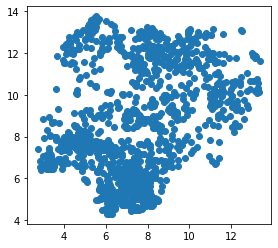

In [168]:
# only for inside train set - worth including or not extensible?
conn_gdf.plot()


In [ ]:
nga_df.to_csv(clean_base, index=False)


# Finally add RWI data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [24]:
from pyquadkey2 import quadkey as qk
from shapely.geometry import Polygon

# qk.QuadKey()
top_left = qk.TileAnchor.ANCHOR_NW
top_right = qk.TileAnchor.ANCHOR_NE
bottom_right = qk.TileAnchor.ANCHOR_SE
bottom_left = qk.TileAnchor.ANCHOR_SW
getattr(qk.TileAnchor, bottom_right)


<TileAnchor.ANCHOR_SE: 3>

In [29]:
test_idx = "010302121"
square = [
    qk.from_str(test_idx).to_geo(anchor=point)
    for point in [top_left, top_right, bottom_right, bottom_left]
]
square = Polygon(square)


In [51]:
import h3.api.numpy_int as h3

ex_idx = h3.geo_to_h3(*square.boundary.coords[0], resolution=6)
hex = Polygon(h3.h3_to_geo_boundary(ex_idx))


In [55]:
# create intersection and calculate percentage intersection based on areas
intersection = hex.intersection(square)
percent_area = intersection.area / square.area * 100


In [56]:
percent_area


8.443662920890045

In [ ]:
nga_df.to_csv(clean_base, index=False)
